# Improving a model

First predictions = baseline predictions
First model = baseline model

From a data perspective: 
* Could we collect mroe data? (generally, the more data the better)
* Could we improve our data? (Stragetically, filling missing values or better encoding)

From a model perspective:
* Is there a better model we could use?
* Could we improve the current model?

Hyperparameters vs Parameters
* Parameters = model find these patterns in data
* Hyperparameters = settings on a model that you can adjust to improve its ability to find patterns

In [1]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
# Example of hyperparameters:
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### I already touched on n_estimators for random forest
So now lets try out:
* max_features (number of feautures considered when looking for best split)
* max_depth (maximum dept of the tree)
* min_sample_leaf (minimum number of sampels required to be at a leaf node)

You can change hyperparameters in 3 ways:
1. Manually
2. Randonly with RandomSearchCV
3. Exhautively with GridSearchCV

## 5.1 Tuning hyperparameters manually


In [4]:
import pandas as pd
import numpy as np

In [7]:
heart_disease = pd.read_csv("../data/heart-disease.csv")
heart_disease.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [8]:
# First, let's get some baseline results
def evaluate_preds(y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels.
    """
    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)
    metric_dict = {"accuracy": round(accuracy, 2),
                   "precision": round(precision, 2), 
                   "recall": round(recall, 2),
                   "f1": round(f1, 2)}
    print(f"Acc: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")

    return metric_dict

In [9]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)

# Shuffle the data
heart_disease = heart_disease.sample(frac=1)

# Split into X & y
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Split the data into train, validation & test sets
train_split = round(0.7 * len(heart_disease)) # 70% of data
valid_split = round(train_split + 0.15 * len(heart_disease)) # 15% of data
X_train, y_train = X[:train_split], y[:train_split]
X_valid, y_valid = X[train_split:valid_split], y[train_split:valid_split]
X_test, y_test = X[valid_split:], y[valid_split:]

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Make predictions
y_preds = clf.predict(X_valid)

# Evaluate the classifier
baseline_metrics = evaluate_preds(y_valid, y_preds)
baseline_metrics

Acc: 82.22%
Precision: 0.81
Recall: 0.88
F1 score: 0.85


{'accuracy': 0.82, 'precision': 0.81, 'recall': 0.88, 'f1': 0.85}

In [10]:
np.random.seed(42)

# Create a second classifier
clf_2 = RandomForestClassifier(n_estimators=100)
clf_2.fit(X_train, y_train)

# Make predictions
y_preds_2 = clf_2.predict(X_valid)

# Evaluate the 2nd classifier
clf_2_metrics = evaluate_preds(y_valid, y_preds_2)

Acc: 82.22%
Precision: 0.84
Recall: 0.84
F1 score: 0.84


## 5.2 Tuning with RandomizedSearchCV

First, create a grid (dictionary) of hyperparameters that we'd to search over
* The values below are made up
But still following the guideline: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [11]:
# Hyperparameter grid RandomizedSearchCV will search over
grid = {"n_estimators": [10, 100, 200, 500, 1000, 1200],
        "max_depth": [None, 5, 10, 20, 30],
        "max_features": ["auto", "sqrt"],
        "min_samples_split": [2, 4, 6],
        "min_samples_leaf": [1, 2, 4]}

### So how many models will this test?
#### As many as for each combination of hyperparameters which is;
* max_depth has 4, 
* max_features has 2, 
* min_samples_leaf has 3, 
* min_samples_split has 3, 
* n_estimators has 5. 
#### That's 4x2x3x3x5 = 360 models
 Or you can set n_iter as a parameter to limit the number of model tests

In [13]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

np.random.seed(42)

# Split into X & y
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set n_jobs to -1 to use all cores (NOTE: n_jobs=-1 is broken as of 8 Dec 2019, using n_jobs=1 works)
clf = RandomForestClassifier(n_jobs=1)

# Setup RandomizedSearchCV
rs_clf = RandomizedSearchCV(estimator=clf,
                            param_distributions=grid,
                            n_iter=20, # try 20 models total
                            cv=5, # 5-fold cross-validation
                            verbose=2) # print out results

# Fit the RandomizedSearchCV version of clf
rs_clf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.4s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.3s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.4s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.3s
[CV] n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5 
[CV]  n_estimators=1200, min_samples_split=6, min_samples_leaf=2, max_features=sqrt, max_depth=5, total=   1.3s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=30 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=30, total=   0.1s
[CV] n_estimators=100, min_samples_split=4, min_samp

[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, total=   0.3s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, total=   0.3s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, total=   0.2s
[CV] n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=200, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, total=   0.3s
[CV] n_estimators=1000, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=20 
[CV]  n_estimators=1000, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=20, total=   1.2s
[CV] n_estimators=1000, min_samples_split=4, min_s

[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.2s
[CV] n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.1s
[CV] n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.1s
[CV] n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=6, min_samples_leaf=2, max_features=auto, max_depth=10, total=   0.1s
[CV] n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10 
[CV]  n_estimators=100, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=10, total=   0.1s
[CV] n_estimators=100, min_samples_split=4, min_samp

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   54.1s finished


In [14]:
#  Find the best hyperparameters found by RandomizedSearchCV
rs_clf.best_params_

{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10}

Now when we call predict() on rs_clf (our RandomizedSearchCV version of our classifier), it'll use the best hyperparameters it found.

In [15]:
# Make predictions with the best hyperparameters
rs_y_preds = rs_clf.predict(X_test)

# Evaluate the predictions
rs_metrics = evaluate_preds(y_test, rs_y_preds)

Acc: 83.61%
Precision: 0.78
Recall: 0.89
F1 score: 0.83


## 5.3 Tuning with GridSearchCV
* Main difference between GridSearchCV & RandomizedSearchCV is that
* GridSearchCV will try every possible combination without a n_iter in mind

Since we've already tried to find some ideal hyperparameters using RandomizedSearchCV, we'll create another hyperparameter grid based on the best_params_ of rs_clf* with less options and then try to use GridSearchCV to find a more ideal set.

In [16]:
# Another hyperparameter grid similar to rs_clf.best_params_
grid_2 = {'n_estimators': [1200, 1500, 2000],
          'max_depth': [None, 5, 10],
          'max_features': ['auto', 'sqrt'],
          'min_samples_split': [4, 6],
          'min_samples_leaf': [1, 2]}
# This is 72 models in total
## So 72 models will be created below

In [17]:

from sklearn.model_selection import GridSearchCV, train_test_split

np.random.seed(42)

# Split into X & y
X = heart_disease.drop("target", axis=1)
y = heart_disease["target"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set n_jobs to -1 to use all cores (NOTE: n_jobs=-1 is broken as of 8 Dec 2019, using n_jobs=1 works)
clf = RandomForestClassifier(n_jobs=1)

# Setup GridSearchCV
gs_clf = GridSearchCV(estimator=clf,
                      param_grid=grid_2,
                      cv=5, # 5-fold cross-validation
                      verbose=2) # print out progress

# Fit the RandomizedSearchCV version of clf
gs_clf.fit(X_train, y_train);


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.4s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.3s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.6s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.7s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.5s
[CV] max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1500 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1500, total=   2.0s
[CV] max_depth=None, max_

[CV]  max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   2.5s
[CV] max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   2.7s
[CV] max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   2.6s
[CV] max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   2.6s
[CV] max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   2.7s
[CV] max_depth=None, max_

[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   1.4s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500, total=   1.7s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500, total=   1.7s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500, total=   1.7s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500, total=   1.7s
[CV] max_depth=None, max_

[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000, total=   2.1s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000, total=   2.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.4s
[CV] max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.3s
[CV] max_depth=5, max_features=auto, min_sa

[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500, total=   1.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500, total=   1.6s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   2.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   2.2s
[CV] max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   2.2s
[CV] max_depth=5, max_features=auto, min_samples_lea

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   1.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   1.3s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500, total=   1.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500, total=   1.7s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500, total=   1.7s
[CV] max_depth=5, max_features=sqrt, min_samples_lea

[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000, total=   2.2s
[CV] max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000 
[CV]  max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000, total=   2.2s
[CV] max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.4s
[CV] max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.3s
[CV] max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=1200, total=   1.3s
[CV] max_depth=10, max_features=auto, min_samp

[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500, total=   1.6s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500, total=   1.7s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=1500, total=   1.6s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   2.2s
[CV] max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=4, n_estimators=2000, total=   2.2s
[CV] max_depth=10, max_features=auto, min_s

[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   1.3s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   1.3s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   1.3s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1200, total=   1.4s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1500, total=   1.7s
[CV] max_depth=10, max_features=sqrt, min_s

[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000, total=   2.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000, total=   2.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000, total=   2.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000, total=   2.2s
[CV] max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=2000, total=   2.1s


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 10.6min finished


In [18]:
# Check the best hyperparameters found with GridSearchCV
gs_clf.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 1200}

In [19]:
# Max predictions with the GridSearchCV classifier
gs_y_preds = gs_clf.predict(X_test)

# Evaluate the predictions
gs_metrics = evaluate_preds(y_test, gs_y_preds)

Acc: 83.61%
Precision: 0.78
Recall: 0.89
F1 score: 0.83


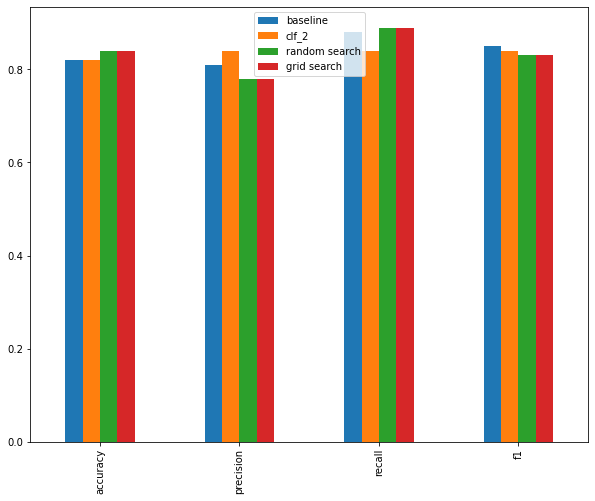

In [20]:
compare_metrics = pd.DataFrame({"baseline": baseline_metrics,
                                "clf_2": clf_2_metrics,
                                "random search": rs_metrics,
                                "grid search": gs_metrics})
compare_metrics.plot.bar(figsize=(10, 8));

## Conclusion 
There is no improvements with other combined hyperparameters

A few things to try:

* Collecting more data - Based on the results our models are getting now, it seems like they're finding some patterns. Collecting more data may improve a models ability to find patterns. However, your ability to do this will largely depend on the project you're working on.
* Try a more advanced model - Although our tuned Random Forest model is doing pretty well, a more advanced ensemble method such as XGBoost or CatBoost might perform better.

# 6. Saving and loading trained models

### 6.1 Save & load with pickle

In [21]:
import pickle 
# Save an existing model to file
pickle.dump(gs_clf, open("gs_random_forest_model_1.pkl", "wb"))

In [23]:
# Load a saved model
loaded_pickle_model = pickle.load(open("gs_random_forest_model_1.pkl", "rb"))

In [24]:
# Try it out

# Make predictions and evaluate the loaded model
pickle_y_preds = loaded_pickle_model.predict(X_test)
evaluate_preds(y_test, pickle_y_preds)

Acc: 83.61%
Precision: 0.78
Recall: 0.89
F1 score: 0.83


{'accuracy': 0.84, 'precision': 0.78, 'recall': 0.89, 'f1': 0.83}

## 6.2 Saving & Loading with joblib
The other way to load and save models is with joblib. Which works relatively the same as pickle.

To save a model, we can use joblib's dump() function, passing it the model (gs_clf) and the desired filename.

In [28]:
from joblib import dump, load

# Save a model to file
dump(gs_clf, filename="gs_random_forest_model_1.joblib")

# Import a saved joblib model
loaded_joblib_model = load(filename="gs_random_forest_model_1.joblib")

In [29]:
# Make and evaluate joblib predictions 
joblib_y_preds = loaded_joblib_model.predict(X_test)
evaluate_preds(y_test, joblib_y_preds)

Acc: 83.61%
Precision: 0.78
Recall: 0.89
F1 score: 0.83


{'accuracy': 0.84, 'precision': 0.78, 'recall': 0.89, 'f1': 0.83}

## 7. Revisit pipeline
It's time for the refinement process
let's use the car_sales regression problem as an example
We will use the Scikit's learn Pipeline class, https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

* Use Kaggle for machine learning exercises/competitions, https://www.kaggle.com/c/titanic

In [31]:
data = pd.read_csv("../data/car-sales-extended-missing-data.csv")
data

,Make,Colour,Odometer (KM),Doors,Price
0,Honda,White,35431.0,4.0,15323.0
1,BMW,Blue,192714.0,5.0,19943.0
2,Honda,White,84714.0,4.0,28343.0
3,Toyota,White,154365.0,4.0,13434.0
4,Nissan,Blue,181577.0,3.0,14043.0
...,...,...,...,...,...
995,Toyota,Black,35820.0,4.0,32042.0
996,NaN,White,155144.0,3.0,5716.0
997,Nissan,Blue,66604.0,4.0,31570.0
998,Honda,White,215883.0,4.0,4001.0


In [32]:
# Getting data ready
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

# Setup random seed
import numpy as np
np.random.seed(42)

# Import data and drop the rows with missing labels
data = pd.read_csv("../data/car-sales-extended-missing-data.csv")
data.dropna(subset=["Price"], inplace=True)

# Define different features and transformer pipelines
categorical_features = ["Make", "Colour"]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

door_feature = ["Doors"]
door_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=4))])

numeric_features = ["Odometer (KM)"]
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean"))
])

# Setup preprocessing steps (fill missing values, then convert to numbers)
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("door", door_transformer, door_feature),
        ("num", numeric_transformer, numeric_features)])

# Create a preprocessing and modelling pipeline
model = Pipeline(steps=[("preprocessor", preprocessor),
                        ("model", RandomForestRegressor())])

# Split data
X = data.drop("Price", axis=1)
y = data["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit and score the model
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.22188417408787875